In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from layers import Linear_Layer
from activation_functions import ReLU, Softmax, Sigmoid, Tanh
from loss_functions import Categorical_Cross_Entropy_Loss, Binary_Cross_Entropy_Loss
from optimizers import Stochastic_Gradient_Descent, Learning_Rate_Scheduler, Stochastic_Gradient_Descent_With_Momentum, AdaGrad, RMSProp, Adadelta, Adam
from metrics import Accuracy, DataLoader

In [2]:
def load_images(file_path):
    with open(file_path, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
        return images

In [3]:
def load_labels(file_path):
    with open(file_path, 'rb') as f:
        _, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

In [4]:
train_images = load_images("MNIST/train-images.idx3-ubyte")
train_labels = load_labels("MNIST/train-labels.idx1-ubyte")
test_images = load_images("MNIST/t10k-images.idx3-ubyte")
test_labels = load_labels("MNIST/t10k-labels.idx1-ubyte")

In [5]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [6]:
def display_images(images, labels, rows, cols):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

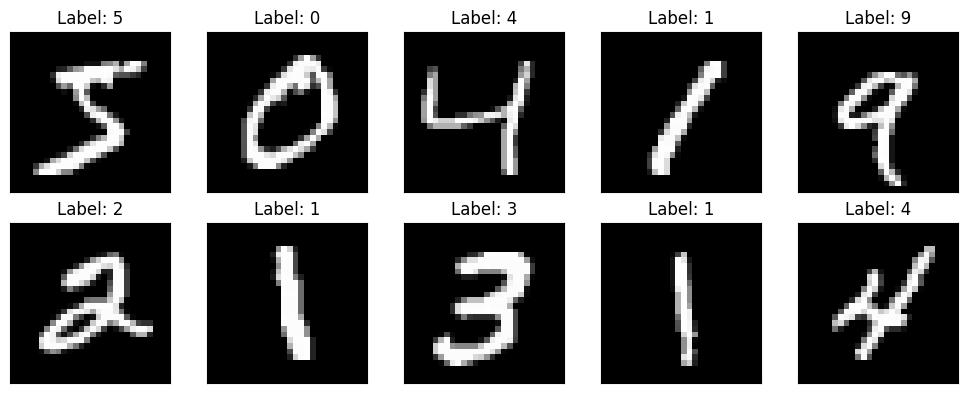

In [7]:
display_images(train_images, train_labels, 2, 5)

In [8]:
n_inputs = 784
n_hidden_1 = 196
n_hidden_2 = 49
n_outputs = 10
num_classes = 10
epochs = 200

In [9]:
class Model:
    def __init__(self, n_inputs, n_hidden_1, n_hidden_2, n_outputs):
        self.L1 = Linear_Layer(n_inputs, n_hidden_1)
        self.tanh = Tanh()
        self.L2 = Linear_Layer(n_hidden_1, n_hidden_2)
        self.relu2 = ReLU()
        self.L3 = Linear_Layer(n_hidden_2, n_outputs)
        self.softmax = Softmax()
    
    def forward(self, inputs):
        outputs = self.L1.forward(inputs)
        outputs = self.tanh.forward(outputs)
        outputs = self.L2.forward(outputs)
        outputs = self.relu2.forward(outputs)
        outputs = self.L3.forward(outputs)
        outputs = self.softmax.forward(outputs)
        return outputs
    
    def num_parameters(self):
        return self.L1.num_parameters() + self.L2.num_parameters() + self.L3.num_parameters()
    
    def backward(self, optimizer, loss, targets, outputs):
        loss.backward(targets, outputs)
        self.softmax.backward(loss.dinputs)
        self.L3.backward(self.softmax.dinputs)
        self.relu2.backward(self.L3.dinputs)
        self.L2.backward(self.relu2.dinputs)
        self.tanh.backward(self.L2.dinputs)
        self.L1.backward(self.tanh.dinputs)
        optimizer.update_params(self.L1)
        optimizer.update_params(self.L2)
        optimizer.update_params(self.L3)
        

In [10]:
enc_train_labels = np.eye(num_classes)[train_labels]
enc_test_labels = np.eye(num_classes)[test_labels]

In [11]:
criterion = Categorical_Cross_Entropy_Loss()
accuracy = Accuracy()

In [12]:
x_images = train_images
x_test = test_images
y_train_labels = enc_train_labels
y_test_labels = enc_test_labels
x_images = x_images.reshape(-1,28 * 28)
x_test = x_test.reshape(-1,28 * 28)

In [13]:
data_loader = DataLoader(x_images, y_train_labels, batch_size=32, shuffle=True)

In [14]:
x_train,y_train = data_loader.batch_data()

Mini-Batch Gradient Descent 

In [15]:
lr = 1e-2

In [16]:
model_1 = Model(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

In [17]:
optimizer = Stochastic_Gradient_Descent(lr=lr)
scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5) 

In [18]:
loss_train = []
loss_test = []

In [19]:
for epoch in range(epochs):
    loss_ep = 0
    total_accuracy = 0
    for x,y in zip(x_train,y_train):
        outputs = model_1.forward(x)
        loss_batch = criterion.forward(y, outputs)
        loss_ep += loss_batch
        batch_acc = accuracy.forward(y, outputs)
        total_accuracy += batch_acc
        model_1.backward(optimizer, criterion, y, outputs)
    loss_ep = loss_ep / len(x_train)
    total_accuracy = total_accuracy/len(x_train)
    loss_train.append(loss_ep)
    outputs = model_1.forward(x_test)
    test_loss_ep = criterion.forward(y_test_labels, outputs)
    loss_test.append(test_loss_ep)
    if (epoch + 1) % 10 == 0:
        test_accuracy = accuracy.forward(y_test_labels, outputs)
        print(f"Epoch: {epoch + 1} / {epochs},Training Loss: {loss_ep:.4f},Training Accuracy: {total_accuracy:.4f}, Test Loss: {test_loss_ep:.4f},Test Accuracy: {test_accuracy:.4f}")

    optimizer.lr = scheduler.update_lr()
    scheduler.update_step()

Epoch: 10 / 200,Training Loss: 0.1393,Training Accuracy: 0.9603, Test Loss: 0.1481,Test Accuracy: 0.9576
Epoch: 20 / 200,Training Loss: 0.0889,Training Accuracy: 0.9751, Test Loss: 0.1127,Test Accuracy: 0.9674
Epoch: 30 / 200,Training Loss: 0.0655,Training Accuracy: 0.9821, Test Loss: 0.0988,Test Accuracy: 0.9704
Epoch: 40 / 200,Training Loss: 0.0520,Training Accuracy: 0.9863, Test Loss: 0.0922,Test Accuracy: 0.9730
Epoch: 50 / 200,Training Loss: 0.0433,Training Accuracy: 0.9891, Test Loss: 0.0889,Test Accuracy: 0.9735
Epoch: 60 / 200,Training Loss: 0.0373,Training Accuracy: 0.9909, Test Loss: 0.0872,Test Accuracy: 0.9739
Epoch: 70 / 200,Training Loss: 0.0331,Training Accuracy: 0.9922, Test Loss: 0.0863,Test Accuracy: 0.9744
Epoch: 80 / 200,Training Loss: 0.0301,Training Accuracy: 0.9930, Test Loss: 0.0858,Test Accuracy: 0.9747
Epoch: 90 / 200,Training Loss: 0.0279,Training Accuracy: 0.9940, Test Loss: 0.0856,Test Accuracy: 0.9751
Epoch: 100 / 200,Training Loss: 0.0262,Training Accurac

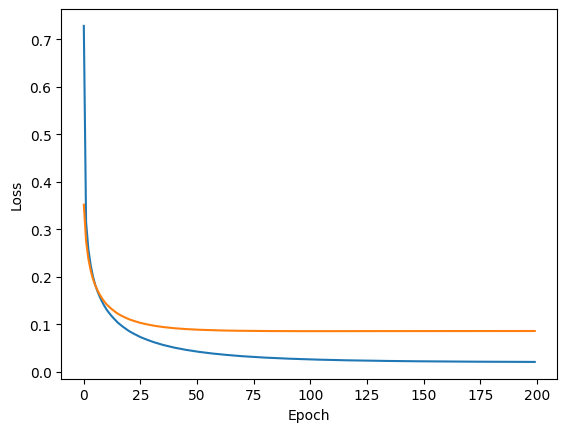

In [20]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Mini-Batch Gradient Descent 

lr = 1e-2

epochs = 200

optimizer = Stochastic_Gradient_Descent(lr=lr)

scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5) 

Training Loss: 0.0207,Training Accuracy: 0.9964, Test Loss: 0.0859,Test Accuracy: 0.9752

Mini-Batch Gradient Descent with Momentum

In [21]:
lr = 5e-2

In [22]:
model_2 = Model(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

In [23]:
optimizer = Stochastic_Gradient_Descent_With_Momentum(lr=lr)
scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5)

In [24]:
loss_train = []
loss_test = []

In [25]:
for epoch in range(epochs):
    loss_ep = 0
    total_accuracy = 0
    for x,y in zip(x_train,y_train):
        outputs = model_2.forward(x)
        loss_batch = criterion.forward(y, outputs)
        loss_ep += loss_batch
        batch_acc = accuracy.forward(y, outputs)
        total_accuracy += batch_acc
        model_2.backward(optimizer, criterion, y, outputs)
    loss_ep = loss_ep / len(x_train)
    total_accuracy = total_accuracy/len(x_train)
    loss_train.append(loss_ep)
    outputs = model_2.forward(x_test)
    test_loss_ep = criterion.forward(y_test_labels, outputs)
    loss_test.append(test_loss_ep)
    if (epoch + 1) % 10 == 0:
        test_accuracy = accuracy.forward(y_test_labels, outputs)
        print(f"Epoch: {epoch + 1} / {epochs},Training Loss: {loss_ep:.4f},Training Accuracy: {total_accuracy:.4f}, Test Loss: {test_loss_ep:.4f},Test Accuracy: {test_accuracy:.4f}")

    optimizer.lr = scheduler.update_lr()
    scheduler.update_step()

Epoch: 10 / 200,Training Loss: 0.0366,Training Accuracy: 0.9908, Test Loss: 0.0790,Test Accuracy: 0.9746
Epoch: 20 / 200,Training Loss: 0.0090,Training Accuracy: 0.9990, Test Loss: 0.0756,Test Accuracy: 0.9775
Epoch: 30 / 200,Training Loss: 0.0037,Training Accuracy: 0.9999, Test Loss: 0.0778,Test Accuracy: 0.9781
Epoch: 40 / 200,Training Loss: 0.0022,Training Accuracy: 1.0000, Test Loss: 0.0800,Test Accuracy: 0.9788
Epoch: 50 / 200,Training Loss: 0.0016,Training Accuracy: 1.0000, Test Loss: 0.0819,Test Accuracy: 0.9786
Epoch: 60 / 200,Training Loss: 0.0013,Training Accuracy: 1.0000, Test Loss: 0.0833,Test Accuracy: 0.9786
Epoch: 70 / 200,Training Loss: 0.0012,Training Accuracy: 1.0000, Test Loss: 0.0842,Test Accuracy: 0.9786
Epoch: 80 / 200,Training Loss: 0.0010,Training Accuracy: 1.0000, Test Loss: 0.0848,Test Accuracy: 0.9787
Epoch: 90 / 200,Training Loss: 0.0010,Training Accuracy: 1.0000, Test Loss: 0.0852,Test Accuracy: 0.9788
Epoch: 100 / 200,Training Loss: 0.0009,Training Accurac

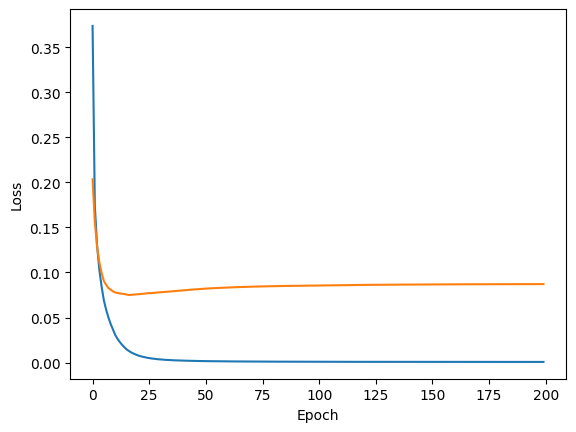

In [26]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Mini-Batch Gradient Descent with Momentum

lr = 5e-2

epochs = 200

optimizer = Stochastic_Gradient_Descent_With_Momentum(lr=lr)

scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5) 

Training Loss: 0.0007,Training Accuracy: 1.0000, Test Loss: 0.0871,Test Accuracy: 0.9790


AdaGrad

In [27]:
lr = 9e-3

In [28]:
model_3 = Model(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

In [29]:
optimizer = AdaGrad(lr=lr)
scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5)

In [30]:
loss_train = []
loss_test = []

In [31]:
for epoch in range(epochs):
    loss_ep = 0
    total_accuracy = 0
    for x,y in zip(x_train,y_train):
        outputs = model_3.forward(x)
        loss_batch = criterion.forward(y, outputs)
        loss_ep += loss_batch
        batch_acc = accuracy.forward(y, outputs)
        total_accuracy += batch_acc
        model_3.backward(optimizer, criterion, y, outputs)
    loss_ep = loss_ep / len(x_train)
    total_accuracy = total_accuracy/len(x_train)
    loss_train.append(loss_ep)
    outputs = model_3.forward(x_test)
    test_loss_ep = criterion.forward(y_test_labels, outputs)
    loss_test.append(test_loss_ep)
    if (epoch + 1) % 10 == 0:
        test_accuracy = accuracy.forward(y_test_labels, outputs)
        print(f"Epoch: {epoch + 1} / {epochs},Training Loss: {loss_ep:.4f},Training Accuracy: {total_accuracy:.4f}, Test Loss: {test_loss_ep:.4f},Test Accuracy: {test_accuracy:.4f}")

    optimizer.lr = scheduler.update_lr()
    scheduler.update_step()

Epoch: 10 / 200,Training Loss: 0.0637,Training Accuracy: 0.9829, Test Loss: 0.0879,Test Accuracy: 0.9737
Epoch: 20 / 200,Training Loss: 0.0414,Training Accuracy: 0.9892, Test Loss: 0.0775,Test Accuracy: 0.9761
Epoch: 30 / 200,Training Loss: 0.0316,Training Accuracy: 0.9928, Test Loss: 0.0738,Test Accuracy: 0.9771
Epoch: 40 / 200,Training Loss: 0.0261,Training Accuracy: 0.9946, Test Loss: 0.0721,Test Accuracy: 0.9779
Epoch: 50 / 200,Training Loss: 0.0227,Training Accuracy: 0.9959, Test Loss: 0.0713,Test Accuracy: 0.9782
Epoch: 60 / 200,Training Loss: 0.0205,Training Accuracy: 0.9966, Test Loss: 0.0708,Test Accuracy: 0.9785
Epoch: 70 / 200,Training Loss: 0.0190,Training Accuracy: 0.9971, Test Loss: 0.0706,Test Accuracy: 0.9788
Epoch: 80 / 200,Training Loss: 0.0178,Training Accuracy: 0.9974, Test Loss: 0.0705,Test Accuracy: 0.9789
Epoch: 90 / 200,Training Loss: 0.0170,Training Accuracy: 0.9976, Test Loss: 0.0704,Test Accuracy: 0.9789
Epoch: 100 / 200,Training Loss: 0.0164,Training Accurac

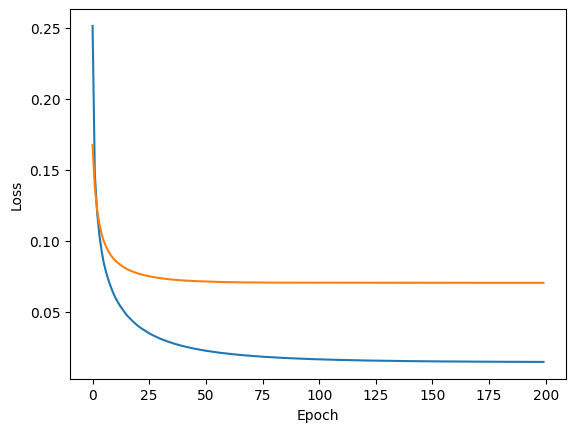

In [32]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

AdaGrad 

lr = 9e-3

epochs = 200

optimizer = AdaGrad(lr=lr)

scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5)

Training Loss: 0.0146,Training Accuracy: 0.9983, Test Loss: 0.0703,Test Accuracy: 0.9789

RMSProp

In [33]:
lr = 1e-4

In [34]:
model_4 = Model(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

In [35]:
optimizer = RMSProp(lr=lr)
scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5)

In [36]:
loss_train = []
loss_test = []

In [37]:
for epoch in range(epochs):
    loss_ep = 0
    total_accuracy = 0
    for x,y in zip(x_train,y_train):
        outputs = model_4.forward(x)
        loss_batch = criterion.forward(y, outputs)
        loss_ep += loss_batch
        batch_acc = accuracy.forward(y, outputs)
        total_accuracy += batch_acc
        model_4.backward(optimizer, criterion, y, outputs)
    loss_ep = loss_ep / len(x_train)
    total_accuracy = total_accuracy/len(x_train)
    loss_train.append(loss_ep)
    outputs = model_4.forward(x_test)
    test_loss_ep = criterion.forward(y_test_labels, outputs)
    loss_test.append(test_loss_ep)
    if (epoch + 1) % 10 == 0:
        test_accuracy = accuracy.forward(y_test_labels, outputs)
        print(f"Epoch: {epoch + 1} / {epochs},Training Loss: {loss_ep:.4f},Training Accuracy: {total_accuracy:.4f}, Test Loss: {test_loss_ep:.4f},Test Accuracy: {test_accuracy:.4f}")

    optimizer.lr = scheduler.update_lr()
    scheduler.update_step()

Epoch: 10 / 200,Training Loss: 0.0991,Training Accuracy: 0.9710, Test Loss: 0.1102,Test Accuracy: 0.9649
Epoch: 20 / 200,Training Loss: 0.0575,Training Accuracy: 0.9838, Test Loss: 0.0851,Test Accuracy: 0.9736
Epoch: 30 / 200,Training Loss: 0.0406,Training Accuracy: 0.9891, Test Loss: 0.0785,Test Accuracy: 0.9762
Epoch: 40 / 200,Training Loss: 0.0315,Training Accuracy: 0.9916, Test Loss: 0.0765,Test Accuracy: 0.9767
Epoch: 50 / 200,Training Loss: 0.0260,Training Accuracy: 0.9931, Test Loss: 0.0759,Test Accuracy: 0.9778
Epoch: 60 / 200,Training Loss: 0.0223,Training Accuracy: 0.9941, Test Loss: 0.0759,Test Accuracy: 0.9779
Epoch: 70 / 200,Training Loss: 0.0199,Training Accuracy: 0.9949, Test Loss: 0.0765,Test Accuracy: 0.9779
Epoch: 80 / 200,Training Loss: 0.0181,Training Accuracy: 0.9956, Test Loss: 0.0772,Test Accuracy: 0.9777
Epoch: 90 / 200,Training Loss: 0.0169,Training Accuracy: 0.9961, Test Loss: 0.0780,Test Accuracy: 0.9776
Epoch: 100 / 200,Training Loss: 0.0160,Training Accurac

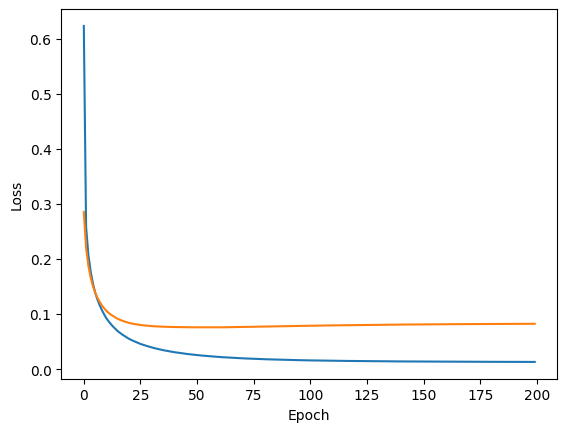

In [38]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

RMS Prop

lr = 1e-4

epoch = 200

optimizer = RMSProp(lr=lr)

scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5)

Training Loss: 0.0131,Training Accuracy: 0.9970, Test Loss: 0.0823,Test Accuracy: 0.9780

Adadelta

In [39]:
model_5 = Model(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

In [40]:
optimizer = Adadelta()

In [41]:
loss_train = []
loss_test = []

In [42]:
for epoch in range(epochs):
    loss_ep = 0
    total_accuracy = 0
    for x,y in zip(x_train,y_train):
        outputs = model_5.forward(x)
        loss_batch = criterion.forward(y, outputs)
        loss_ep += loss_batch
        batch_acc = accuracy.forward(y, outputs)
        total_accuracy += batch_acc
        model_5.backward(optimizer, criterion, y, outputs)
    loss_ep = loss_ep / len(x_train)
    total_accuracy = total_accuracy/len(x_train)
    loss_train.append(loss_ep)
    outputs = model_5.forward(x_test)
    test_loss_ep = criterion.forward(y_test_labels, outputs)
    loss_test.append(test_loss_ep)
    if (epoch + 1) % 10 == 0:
        test_accuracy = accuracy.forward(y_test_labels, outputs)
        print(f"Epoch: {epoch + 1} / {epochs},Training Loss: {loss_ep:.4f},Training Accuracy: {total_accuracy:.4f}, Test Loss: {test_loss_ep:.4f},Test Accuracy: {test_accuracy:.4f}")


Epoch: 10 / 200,Training Loss: 0.0222,Training Accuracy: 0.9947, Test Loss: 0.0865,Test Accuracy: 0.9771
Epoch: 20 / 200,Training Loss: 0.0052,Training Accuracy: 0.9989, Test Loss: 0.1215,Test Accuracy: 0.9765
Epoch: 30 / 200,Training Loss: 0.0020,Training Accuracy: 0.9996, Test Loss: 0.1565,Test Accuracy: 0.9752
Epoch: 40 / 200,Training Loss: 0.0009,Training Accuracy: 0.9998, Test Loss: 0.1918,Test Accuracy: 0.9739
Epoch: 50 / 200,Training Loss: 0.0006,Training Accuracy: 0.9999, Test Loss: 0.2035,Test Accuracy: 0.9754
Epoch: 60 / 200,Training Loss: 0.0003,Training Accuracy: 1.0000, Test Loss: 0.2099,Test Accuracy: 0.9765
Epoch: 70 / 200,Training Loss: 0.0001,Training Accuracy: 1.0000, Test Loss: 0.2157,Test Accuracy: 0.9763
Epoch: 80 / 200,Training Loss: 0.0000,Training Accuracy: 1.0000, Test Loss: 0.2183,Test Accuracy: 0.9767
Epoch: 90 / 200,Training Loss: 0.0000,Training Accuracy: 1.0000, Test Loss: 0.2189,Test Accuracy: 0.9773
Epoch: 100 / 200,Training Loss: 0.0000,Training Accurac

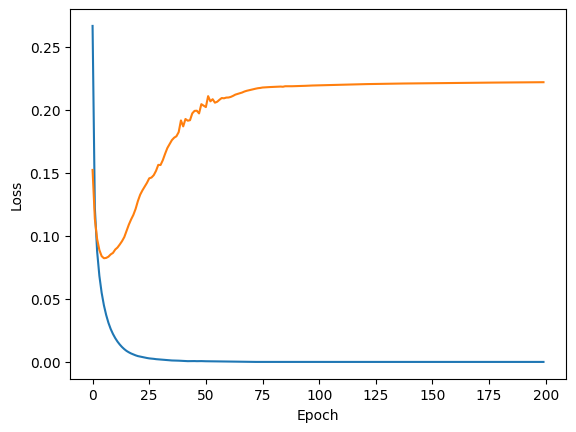

In [43]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Adadelta

lr = No need

epochs = 200

optimizer = Adadelta()

scheduler = No need

Training Loss: 0.0000,Training Accuracy: 1.0000, Test Loss: 0.2221,Test Accuracy: 0.9766

Adam

In [44]:
lr = 5e-5

In [45]:
optimizer = Adam(lr=lr, beta1=0.99, beta2=0.99)
scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5)

In [46]:
model_6 = Model(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

In [47]:
loss_train = []
loss_test = []

In [48]:
for epoch in range(epochs):
    loss_ep = 0
    total_accuracy = 0
    for x,y in zip(x_train,y_train):
        outputs = model_6.forward(x)
        loss_batch = criterion.forward(y, outputs)
        loss_ep += loss_batch
        batch_acc = accuracy.forward(y, outputs)
        total_accuracy += batch_acc
        model_6.backward(optimizer, criterion, y, outputs)
    loss_ep = loss_ep / len(x_train)
    total_accuracy = total_accuracy/len(x_train)
    loss_train.append(loss_ep)
    outputs = model_6.forward(x_test)
    test_loss_ep = criterion.forward(y_test_labels, outputs)
    loss_test.append(test_loss_ep)
    if (epoch + 1) % 10 == 0:
        test_accuracy = accuracy.forward(y_test_labels, outputs)
        print(f"Epoch: {epoch + 1} / {epochs},Training Loss: {loss_ep:.4f},Training Accuracy: {total_accuracy:.4f}, Test Loss: {test_loss_ep:.4f},Test Accuracy: {test_accuracy:.4f}")

    optimizer.lr = scheduler.update_lr()
    scheduler.update_step()

Epoch: 10 / 200,Training Loss: 0.1400,Training Accuracy: 0.9588, Test Loss: 0.1433,Test Accuracy: 0.9581
Epoch: 20 / 200,Training Loss: 0.0855,Training Accuracy: 0.9759, Test Loss: 0.1030,Test Accuracy: 0.9693
Epoch: 30 / 200,Training Loss: 0.0604,Training Accuracy: 0.9837, Test Loss: 0.0876,Test Accuracy: 0.9726
Epoch: 40 / 200,Training Loss: 0.0458,Training Accuracy: 0.9881, Test Loss: 0.0801,Test Accuracy: 0.9750
Epoch: 50 / 200,Training Loss: 0.0364,Training Accuracy: 0.9913, Test Loss: 0.0760,Test Accuracy: 0.9767
Epoch: 60 / 200,Training Loss: 0.0300,Training Accuracy: 0.9932, Test Loss: 0.0735,Test Accuracy: 0.9770
Epoch: 70 / 200,Training Loss: 0.0255,Training Accuracy: 0.9947, Test Loss: 0.0720,Test Accuracy: 0.9778
Epoch: 80 / 200,Training Loss: 0.0222,Training Accuracy: 0.9955, Test Loss: 0.0711,Test Accuracy: 0.9785
Epoch: 90 / 200,Training Loss: 0.0197,Training Accuracy: 0.9963, Test Loss: 0.0706,Test Accuracy: 0.9788
Epoch: 100 / 200,Training Loss: 0.0179,Training Accurac

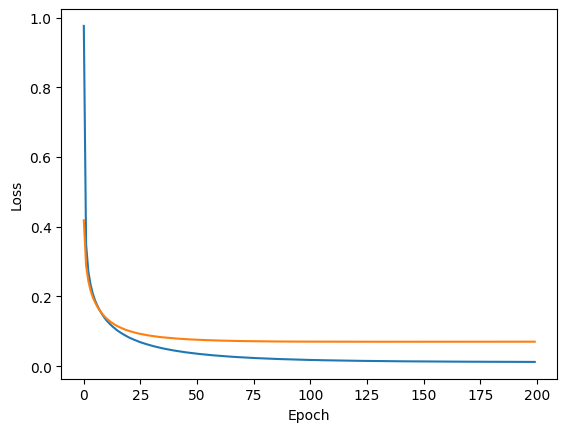

In [49]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Adam Optimizer:

lr = 5e-5

epochs = 200

optimizer = Adam(lr=lr, beta1=0.99, beta2=0.99)

scheduler = Learning_Rate_Scheduler(learning_rate=lr, decay_rate=0.9, decay_step=5)

Training Loss: 0.0121,Training Accuracy: 0.9985, Test Loss: 0.0701,Test Accuracy: 0.9802